In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob

trainval = pd.read_csv('../data/caterpillar/train_set.csv')
test = pd.read_csv('../data/caterpillar/test_set.csv')

trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)

train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

train.shape, val.shape, test.shape

((22628, 8), (7585, 8), (30235, 8))

In [3]:
for path in glob('../data/caterpillar/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

../data/caterpillar/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

../data/caterpillar/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

../data/caterpillar/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

../data/caterpillar/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'] 

../data/caterpillar/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3',

In [4]:
def wrangle(data):
    data = data.copy()
    
    # Engineer date features
    data['quote_date'] = pd.to_datetime(data['quote_date'], infer_datetime_format=True)
    data['quote_date_year'] = data['quote_date'].dt.year
    data['quote_date_month'] = data['quote_date'].dt.month
    data = data.drop(columns='quote_date')
    
    # Merge data
    tube = pd.read_csv('../data/caterpillar/tube.csv')
    bill_of_materials = pd.read_csv('../data/caterpillar/bill_of_materials.csv')
    specs = pd.read_csv('../data/caterpillar/specs.csv')
    data = data.merge(tube, how='left')
    data = data.merge(bill_of_materials, how='left')
    data = data.merge(specs, how='left')

    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    data = data.drop(columns='tube_assembly_id')
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

print(train.shape, val.shape, test.shape)

(22628, 49) (7585, 49) (30235, 49)


In [5]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

0.08436212138880193
0.24570334673279667


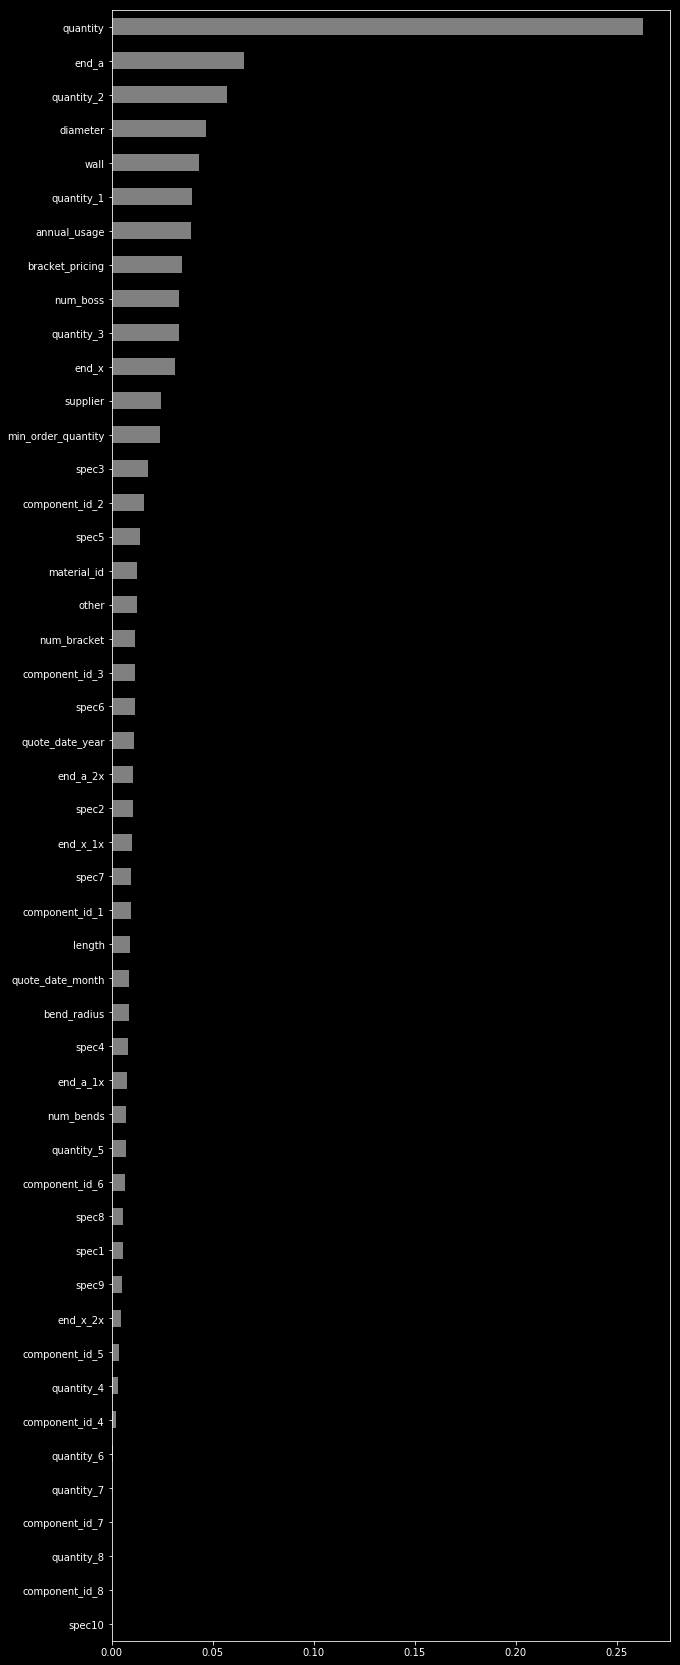

In [8]:
import numpy as np
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

target = 'cost'

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

y_train = train[target]
y_val = val[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(max_depth=7,
                 n_estimators=1000,
                 n_jobs=-1,
                 gamma=.05,
                 colsample_bytree=.3,
                 reg_alpha=.1,
                 reg_lambda=.95,
                 objective='reg:squarederror')
)

pipeline.fit(X_train, np.array(y_train_log))
y_train_pred_log = pipeline.predict(X_train)
y_val_pred_log = pipeline.predict(X_val)

print(rmse(y_train_log, y_train_pred_log))
print(rmse(y_val_log, y_val_pred_log))

coefficients = pd.Series(pipeline[1].feature_importances_,
                         X_train.columns.tolist())
plt.style.use('dark_background')
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');
plt.show()

In [14]:
X_test = test.drop(columns='id')
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

sample_submission = pd.read_csv('../data/caterpillar/sample_submission.csv')

submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('nathan_van_wyck_submission.csv', index=False)